# Plot astrometric orbits for RV samples

In this example, we'll assume (1) we know the sky position and distance of the barycenter of the observed two-body system at some epoch, and (2) we later observe some radial velocity data for the primary star. We'll use the radial velocity measurements to empirically estimate the amplitude of the astrometric orbit.

In [1]:
import astropy.coordinates as coord
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import schwimmbad
%matplotlib inline

from twobody import KeplerOrbit, Barycenter, P_m_to_a
from thejoker import RVData, JokerPrior, TheJoker
from thejoker.plot import plot_rv_curves

rnd = np.random.RandomState(seed=123)

To generate simulated data, we'll simulate observations of the exoplanet host GJ 876 (with parameters taken from [exoplanets.org](http://exoplanets.org/detail/GJ_876_b)). We'll assume the star's parallax, radial velocity, and sky position are that of the barycenter of the system, and that these are known.

In [2]:
origin = coord.SkyCoord(ra='22 53 16.73352', dec='-14 15 49.3186', 
                        unit=(u.hourangle, u.deg),
                        distance=4.689*u.pc, 
                        radial_velocity=-1.519*u.km/u.s)
barycenter = Barycenter(origin=origin, t0=Time('J2000'))

In [3]:
m1 = 0.320*u.Msun
m2 = 1.95*u.Mjup

truth = dict()
truth['P'] = 61.1166 * u.day
truth['a'] = 0.2081*u.au * m2 / m1 # convert a2 to a1
truth['e'] = 0.0324
truth['M0'] = 0 * u.radian
truth['t0'] = Time(2450546.80, format='jd', scale='utc')
truth['omega'] = 50.3 * u.degree
truth['barycenter'] = barycenter

orbit = KeplerOrbit(**truth, 
                    Omega=0*u.deg, i=90*u.deg) # these angle don't matter for radial velocity

We'll generate 31 randomly spaced "observations" from some arbitrary epoch (MJD=58140.8) over ~1 year, with uncertainties of 25 m/s:

In [4]:
n_data = 31
t = Time(58140.8 + rnd.uniform(0, 350, n_data), 
         format='mjd', scale='tcb')
t.sort()
rv = orbit.radial_velocity(t)

err = np.full(len(t), 25) * u.m/u.s
rv = rv + rnd.normal(0, err.value)*err.unit

Text(0.5, 1.0, 'simulated data')

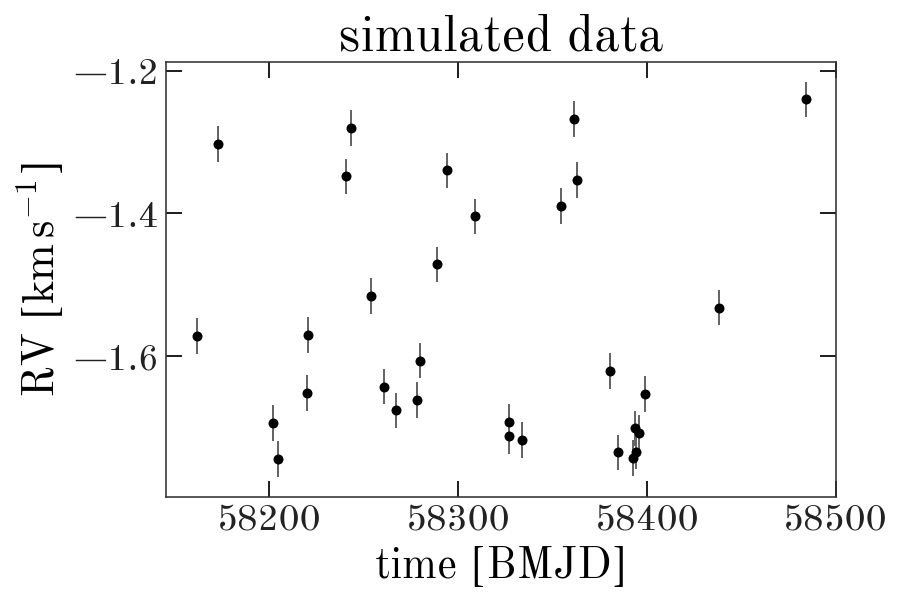

In [5]:
data = RVData(t, rv, err)

ax = data.plot()
ax.set_title('simulated data')

Next, we'll run The Joker with a fairly constrained period range to infer the orbital parameters consistent with these data. To start, we have to specify the hyperparameters (period prior bounds):

In [6]:
prior = JokerPrior.default(P_min=8*u.day, P_max=256*u.day, 
                           sigma_K0=15*u.km/u.s, P0=60*u.day,
                           sigma_v=100*u.km/u.s)

We'll generate 1,000,000 prior samples to rejection sample with:

In [7]:
prior_samples = prior.sample(size=1_000_000)

We can now run The Joker by passing the data and prior samples:

In [8]:
%%time
with schwimmbad.MultiPool() as pool:
    joker = TheJoker(prior, pool=pool)
    samples = joker.rejection_sample(data, prior_samples)
len(samples)

CPU times: user 1.31 s, sys: 178 ms, total: 1.48 s
Wall time: 5.56 s


8

Let's now visualize some of the orbits defined by those samples, plotted over the "data":

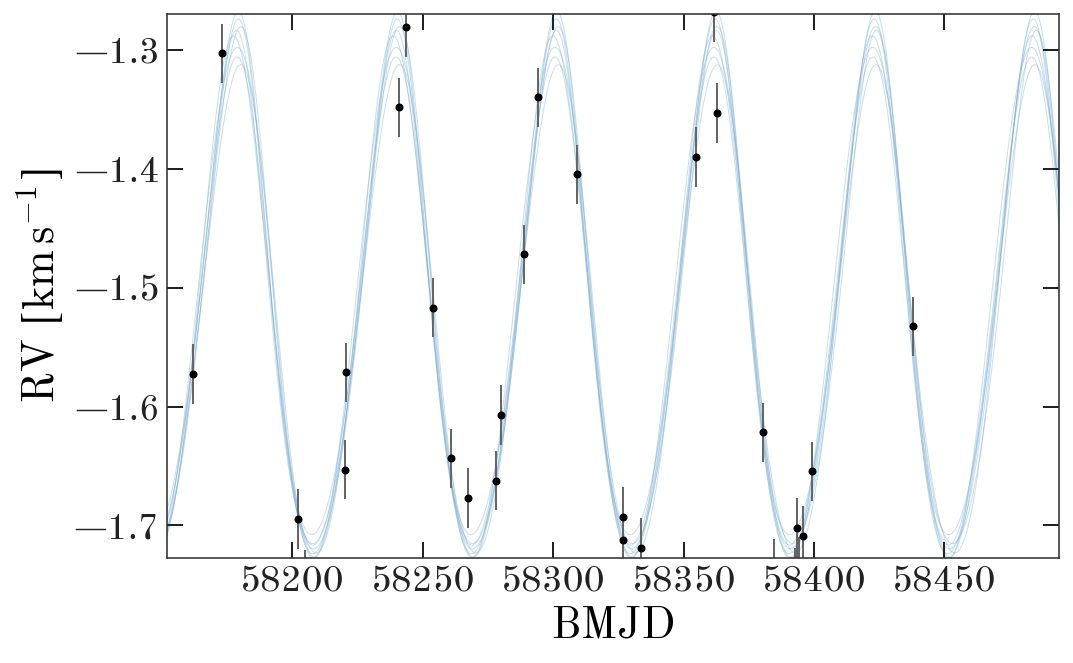

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8,5)) 
t_grid = np.linspace(data.t.mjd.min()-10, data.t.mjd.max()+10, 1024)
fig = plot_rv_curves(samples, t_grid, rv_unit=u.km/u.s, data=data, ax=ax,
                     plot_kwargs=dict(color='#74a9cf', zorder=-100))

It looks like all of the samples returned are within the same period mode. We'll take the mean of the samples to compress the posterior and use the mean values as our assumed orbit fit:

In [10]:
mean_sample = samples.mean()
mean_sample

<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>

Now, we'd like to see what astrometric orbits are generated by these orbital parameters. But, the radial velocity measurements alone don't constrain two more key orbital elements needed to compute the astrometric orbits: the inclination of the orbit, $i$ or in code `i`, and the longitude of the ascending node, $\Omega$ or in code `Omega`. We also need to specify a coordinate frame to transform the orbit to. For the former, we'll generate samples in the angles assuming the probability of the orbital orientation is isotropic in these angles: uniform in $\cos i$ and uniform in $\Omega$. For the latter, we'll use a spherical coordinate system centered on the position of the barycenter at the epoch we specified, with longitude and latitude that increase in the same sense as the ICRS frame. If you scroll up, this sky location is `ra='22 53 16.73352'`, `dec='-14 15 49.3186'`, and the epoch is J2000. We can use astropy to transform to this frame using the `astropy.coordinates.SkyOffsetFrame` with a specified origin:

In [11]:
barycenter_frame = coord.SkyOffsetFrame(origin=barycenter.origin)

Text(0, 0.5, '$\\Delta \\delta$ [$\\mathrm{mas}$]')

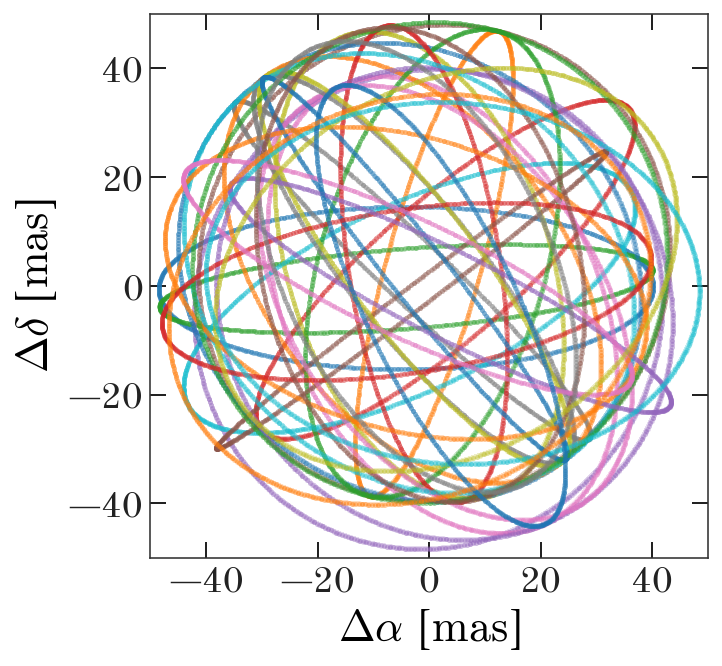

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for j in range(32):
    a = P_m_to_a(mean_sample['P'], m1+m2)
    orbit_sample = mean_sample.get_orbit(0, a=a, 
        i=np.arccos(np.random.uniform(0, 1)) * u.rad, 
        Omega=np.random.uniform(0, 2*np.pi) * u.rad,
        barycenter=barycenter)
    
    t_grid = Time('J2014') + np.linspace(0, 5, 1000) * u.year
    ref_plane = orbit_sample.reference_plane(t_grid)
    icrs = orbit_sample.icrs(t_grid)
    sky_offset = icrs.transform_to(barycenter_frame)

    ax.plot(sky_offset.lon.wrap_at(180*u.deg).milliarcsecond, 
            sky_offset.lat.milliarcsecond, 
            alpha=0.25, linestyle='-')
    
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)

ax.set_xlabel(r'$\Delta \alpha$ [{0:latex_inline}]'.format(u.mas))
ax.set_ylabel(r'$\Delta \delta$ [{0:latex_inline}]'.format(u.mas))

For this system, the expected astrometric deviations from a straight-line (due to the barycentric proper motion) are around ~40 milliarcseconds. If we know the proper motion of the barycenter, or if we assume that the proper motion of the host star is the same as the proper motion of the barycenter, we can predict the full astrometric orbit of the system. To do this, we have to define a `Barycenter` object with proper motion components:

In [13]:
origin_pm = coord.SkyCoord(ra='22 53 16.73352', dec='-14 15 49.3186', 
                           unit=(u.hourangle, u.deg),
                           distance=4.689*u.pc, 
                           pm_ra_cosdec=959.84*u.mas/u.yr,
                           pm_dec=-675.33*u.mas/u.yr,
                           radial_velocity=-1.519*u.km/u.s)
barycenter_pm = Barycenter(origin=origin_pm, t0=Time('J2000'))

Text(0, 0.5, '$\\Delta \\delta$ [$\\mathrm{mas}$]')

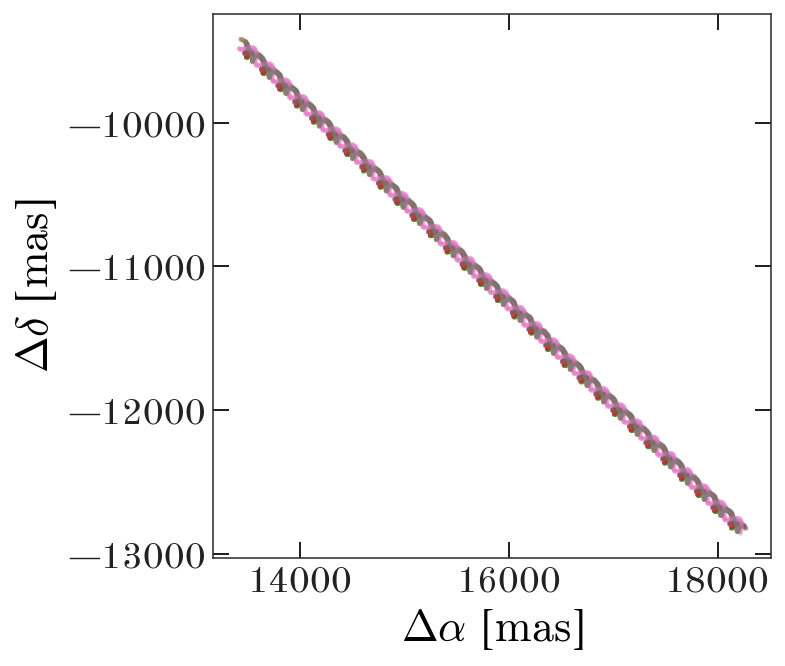

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for j in range(8):
    a = P_m_to_a(mean_sample['P'], m1+m2)
    orbit_sample = mean_sample.get_orbit(0, a=a, 
        i=np.arccos(np.random.uniform(0, 1)) * u.rad, 
        Omega=np.random.uniform(0, 2*np.pi) * u.rad,
        barycenter=barycenter_pm)
    
    t_grid = Time('J2014') + np.linspace(0, 5, 1000) * u.year
    ref_plane = orbit_sample.reference_plane(t_grid)
    icrs = orbit_sample.icrs(t_grid)
    sky_offset = icrs.transform_to(barycenter_frame)

    ax.plot(sky_offset.lon.wrap_at(180*u.deg).milliarcsecond, 
            sky_offset.lat.milliarcsecond, 
            alpha=0.25, linestyle='-')

ax.set_xlabel(r'$\Delta \alpha$ [{0:latex_inline}]'.format(u.mas))
ax.set_ylabel(r'$\Delta \delta$ [{0:latex_inline}]'.format(u.mas))